In [1]:
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torch.optim as optim
import torch.nn as nn
import numpy as np
import sys
from vit.vit import VisionTransformer
import time
import pandas as pd
from torchmetrics import Precision, Recall
import warnings
from torchvision.models import resnet18
warnings.filterwarnings('ignore')

from torchvision import transforms
from torchvision.transforms import functional as F
import pandas as pd
import albumentations as A

In [2]:
transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ], p=0.8),
    A.Rotate(limit=90, p=0.5),
    A.Resize(32, 32)
])





pd.options.mode.chained_assignment = 'warn'
torch.cuda.empty_cache()

model = resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

num_classes = 4
model.fc = nn.Sequential(
    nn.Dropout(0.6),  
    nn.Linear(model.fc.in_features, num_classes))


batch_size = 16

trainset = PlantDataset('datasets/training_data.csv', 'images')
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=4)


testset = PlantDataset('datasets/valid_data.csv', 'images')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=4)

model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)

precisions = []
precisions_val = []

recalls = []
val_recalls = []

losses = []
val_losses = []


metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

metric_precision_val = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall_val = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

EPOCHS = 100

In [3]:
for epoch in range(EPOCHS):
    recall = []
    precision = []

    recall_val = []
    precision_val = []

    training_loss = []
    start_time = time.time()
    elapsed_time = 0
    model.train() 
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
    
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)


        metric_precision(outputs, labels)
        metric_recall(outputs, labels)



        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())

        if (i + 1) % 5 == 0 or i == len(trainloader) - 1:
            elapsed_time = time.time() - start_time
            batches_done = i + 1
            batches_total = len(trainloader)
            batches_remaining = batches_total - batches_done
            time_per_batch = elapsed_time / batches_done
            estimated_time_remaining = time_per_batch * batches_remaining

            elapsed_time_minutes = elapsed_time / 60
            estimated_time_remaining_minutes = estimated_time_remaining / 60

            progress_message = f'Batch {i}/{len(trainloader)},Remaining: {estimated_time_remaining_minutes:.2f}min'
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()

        

 
    model.eval()  
    val_loss = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            labels = torch.Tensor(labels)
            inputs = inputs.to('cuda:0')
            labels = labels.to('cuda:0')


            outputs = model(inputs)
            val_loss_crt = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            metric_precision_val(outputs, labels)
            metric_recall_val(outputs, labels)


            val_loss.append(val_loss_crt.item())

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    precision_val = metric_precision_val.compute()
    recall_val = metric_recall_val.compute()

    precisions.append(precision)
    precisions_val.append(precision_val)

    recalls.append(recall)
    val_recalls.append(recall_val)
    
    losses.append(np.mean(training_loss))
    val_losses.append(np.mean(val_loss))
    
    print(f'Epoch {epoch + 1}, Training loss: {np.m ean(training_loss)} Validation Loss: {np.mean(val_loss)}')
    
    print(f'Epoch {epoch + 1}, Training Class 1: {precision[0]}, Class 2: {precision[1]}, Class 3: {precision[2]}, Class 4: {precision[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {precision_val[0]}, Class 2: {precision_val[1]}, Class 3: {precision_val[2]}, Class 4: {precision_val[3]}')

    print(f'Epoch {epoch + 1}, Training Class 1: {recall[0]}, Class 2: {recall[1]}, Class 3: {recall[2]}, Class 4: {recall[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {recall_val[0]}, Class 2: {recall_val[1]}, Class 3: {recall_val[2]}, Class 4: {recall_val[3]}')

    

print('Finished Training')
print('Finished Training')

Batch 581/582,Remaining: 0.00minEpoch 1, Training loss: 1.3396262375324248 Validation Loss: 1.1820244045596418
Epoch 1, Training Class 1: 0.32279908657073975, Class 2: 0.11538461595773697, Class 3: 0.3733333349227905, Class 4: 0.40312498807907104
Epoch 1, Validation Class 1: 0.4301075339317322, Class 2: 0.0, Class 3: 0.43661972880363464, Class 4: 0.4609375
Epoch 1, Training Class 1: 0.4333333373069763, Class 2: 0.050847455859184265, Class 3: 0.35264483094215393, Class 4: 0.341269850730896
Epoch 1, Validation Class 1: 0.4819277226924896, Class 2: 0.0, Class 3: 0.3100000023841858, Class 4: 0.621052622795105
Batch 581/582,Remaining: 0.00minEpoch 2, Training loss: 1.3058169226440572 Validation Loss: 1.1941821738465193
Epoch 2, Training Class 1: 0.3290322721004486, Class 2: 0.11538461595773697, Class 3: 0.3839285671710968, Class 4: 0.39030954241752625
Epoch 2, Validation Class 1: 0.4516128897666931, Class 2: 0.0, Class 3: 0.41847825050354004, Class 4: 0.4653061330318451
Epoch 2, Training Cl

In [4]:
torch.save(model.state_dict(),'models/model_resnet18_2.pth')
df = pd.DataFrame()
df['loss'] = np.array(losses)
df['val_loss'] = np.array(val_losses)

df['recall'] = [list(recall.cpu().numpy()) for recall in recalls]
df['val_recall'] = [list(val_recall.cpu().numpy()) for val_recall in val_recalls]

df['precision'] = [list(precision.cpu().numpy()) for precision in precisions] 
df['val_precision'] = [list(val_precision.cpu().numpy()) for val_precision in precisions_val]
df.to_csv('model2.csv')

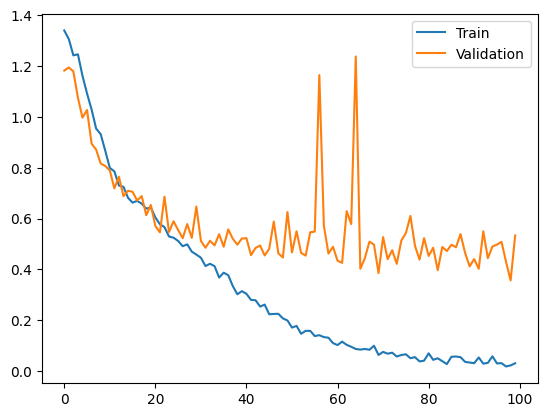

In [5]:
plt.plot(df['loss'], label='Train')
plt.plot(df['val_loss'], label='Validation')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()

          

            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(y_pred)
        print(y_test)
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

dataset = PlantDataset('datasets/testing_data.csv', 'images')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

test_report(model.to('cpu'), dataloader)

[3, 1, 2, 0, 1, 3, 0, 3, 3, 3, 0, 0, 2, 1, 3, 3, 0, 3, 2, 0, 3, 0, 1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 0, 3, 3, 2, 1, 2, 3, 0, 3, 1, 3, 2, 3, 0, 3, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 3, 0, 3, 3, 3, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 3, 3, 2, 0, 2, 0, 2, 2, 0, 0, 3, 0, 2, 2, 3, 2, 3, 2, 0, 1, 2, 2, 3, 2, 3, 0, 3, 0, 1, 3, 0, 1, 0, 0, 3, 2, 2, 2, 2, 0, 3, 0, 0, 0, 3, 3, 1, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 1, 2, 2, 1, 1, 3, 3, 0, 0, 3, 0, 3, 3, 3, 2, 2, 0, 0, 3, 0, 3, 0, 2, 2, 0, 0, 3, 1, 0, 0, 3, 3, 0, 3, 0, 2, 0, 3, 3, 1, 2, 1, 3, 3, 0, 3, 1, 0, 3, 1, 2, 3, 2, 1, 3, 0, 3, 0, 0, 0, 0, 1, 1, 3, 1, 3, 2, 0, 3, 0, 2, 3, 0, 2, 0, 0, 0, 2, 2, 3, 2, 0, 2, 0, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 3, 3, 3, 2, 0, 0, 1, 2, 2, 2, 3, 3, 0, 0, 2, 2, 0, 0, 3, 0, 1, 3, 0, 2, 3, 3, 2, 0, 3, 2, 0, 0, 2, 0, 2, 1, 2, 3, 0, 0, 2, 0, 2, 3, 3, 1, 2, 1, 3, 1, 0, 2, 0, 3, 2, 2, 0, 1, 0, 0, 3, 0, 0, 3, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 3, 2, 3, 0, 0, 